# P1.2 QUANTUM NN
Alejando Mayorga Redondo
Fernando Mondragón Sampedro

### Introducción


En esta práctica, realizaremos la implementación de una red neuronal cuántica la cual permita clasificar vinos en base a 3 categorías distintas, partiendo de 13 características tales como volumen de alcohol o acidez. 

### Preprocesado

Primeramente, es necesario realizar un preprocesado de los datos, de forma que se ajusten a una entrada manipulable por la red, para esto, dividimos las características y etiquetas en conjuntos de entrenamiento y test, para después llamar a la función MinMaxScaler, encargada de normalizar los datos, para después aplicar una función de one hot encoder, que nos permite disponer las etiquetas de forma adecuada para su clasificación en una de las tres categorías.

In [14]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
import numpy as np
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC

wine_data = load_wine()
features = wine_data.data
labels = wine_data.target

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)

features_train = MinMaxScaler().fit_transform(features_train)

features_test = MinMaxScaler().fit_transform(features_test)

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(labels_train.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(labels_test.reshape(-1, 1)).toarray()




### Desarrollo de la QNN


#### State preparation

Ahora debemos de preparar el circuíto que nos permitirá realizar la clasificación. De entre todas las posibles opciones para armarlo, decidimo optar por ZZFeatureMap debido a ?

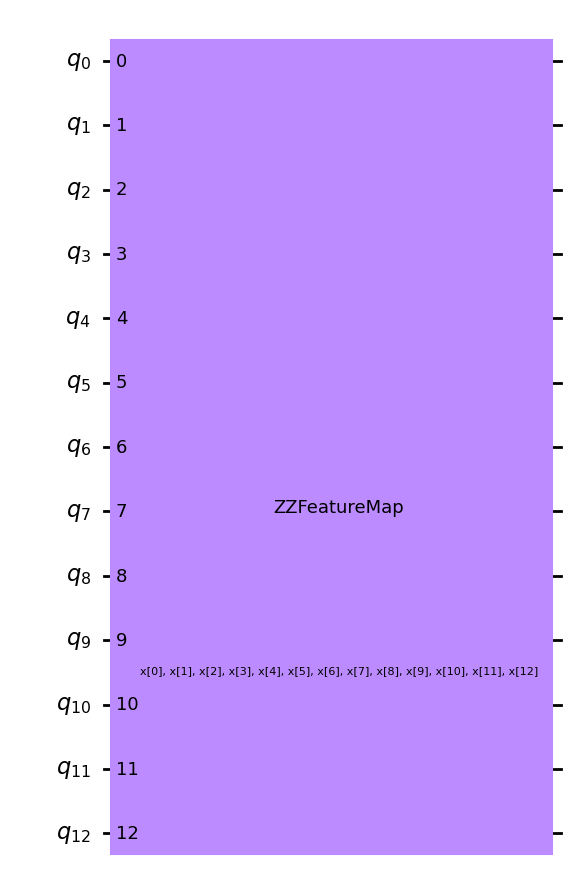

In [15]:
#Primero escogemos un método de encoding para las features. En nuestro caso optamos por el ZZFeatureMap
from qiskit.circuit.library import ZZFeatureMap
featureMap = ZZFeatureMap(feature_dimension=13, reps=1)
#featureMap.decompose().draw("mpl")
featureMap.draw("mpl")


#### Circuito clasificador


Para realizar la clasificación persé, es necesario crear otro circuíto conocido como modelo. Para este fin, empleamos el TwoLocal debido a ? 

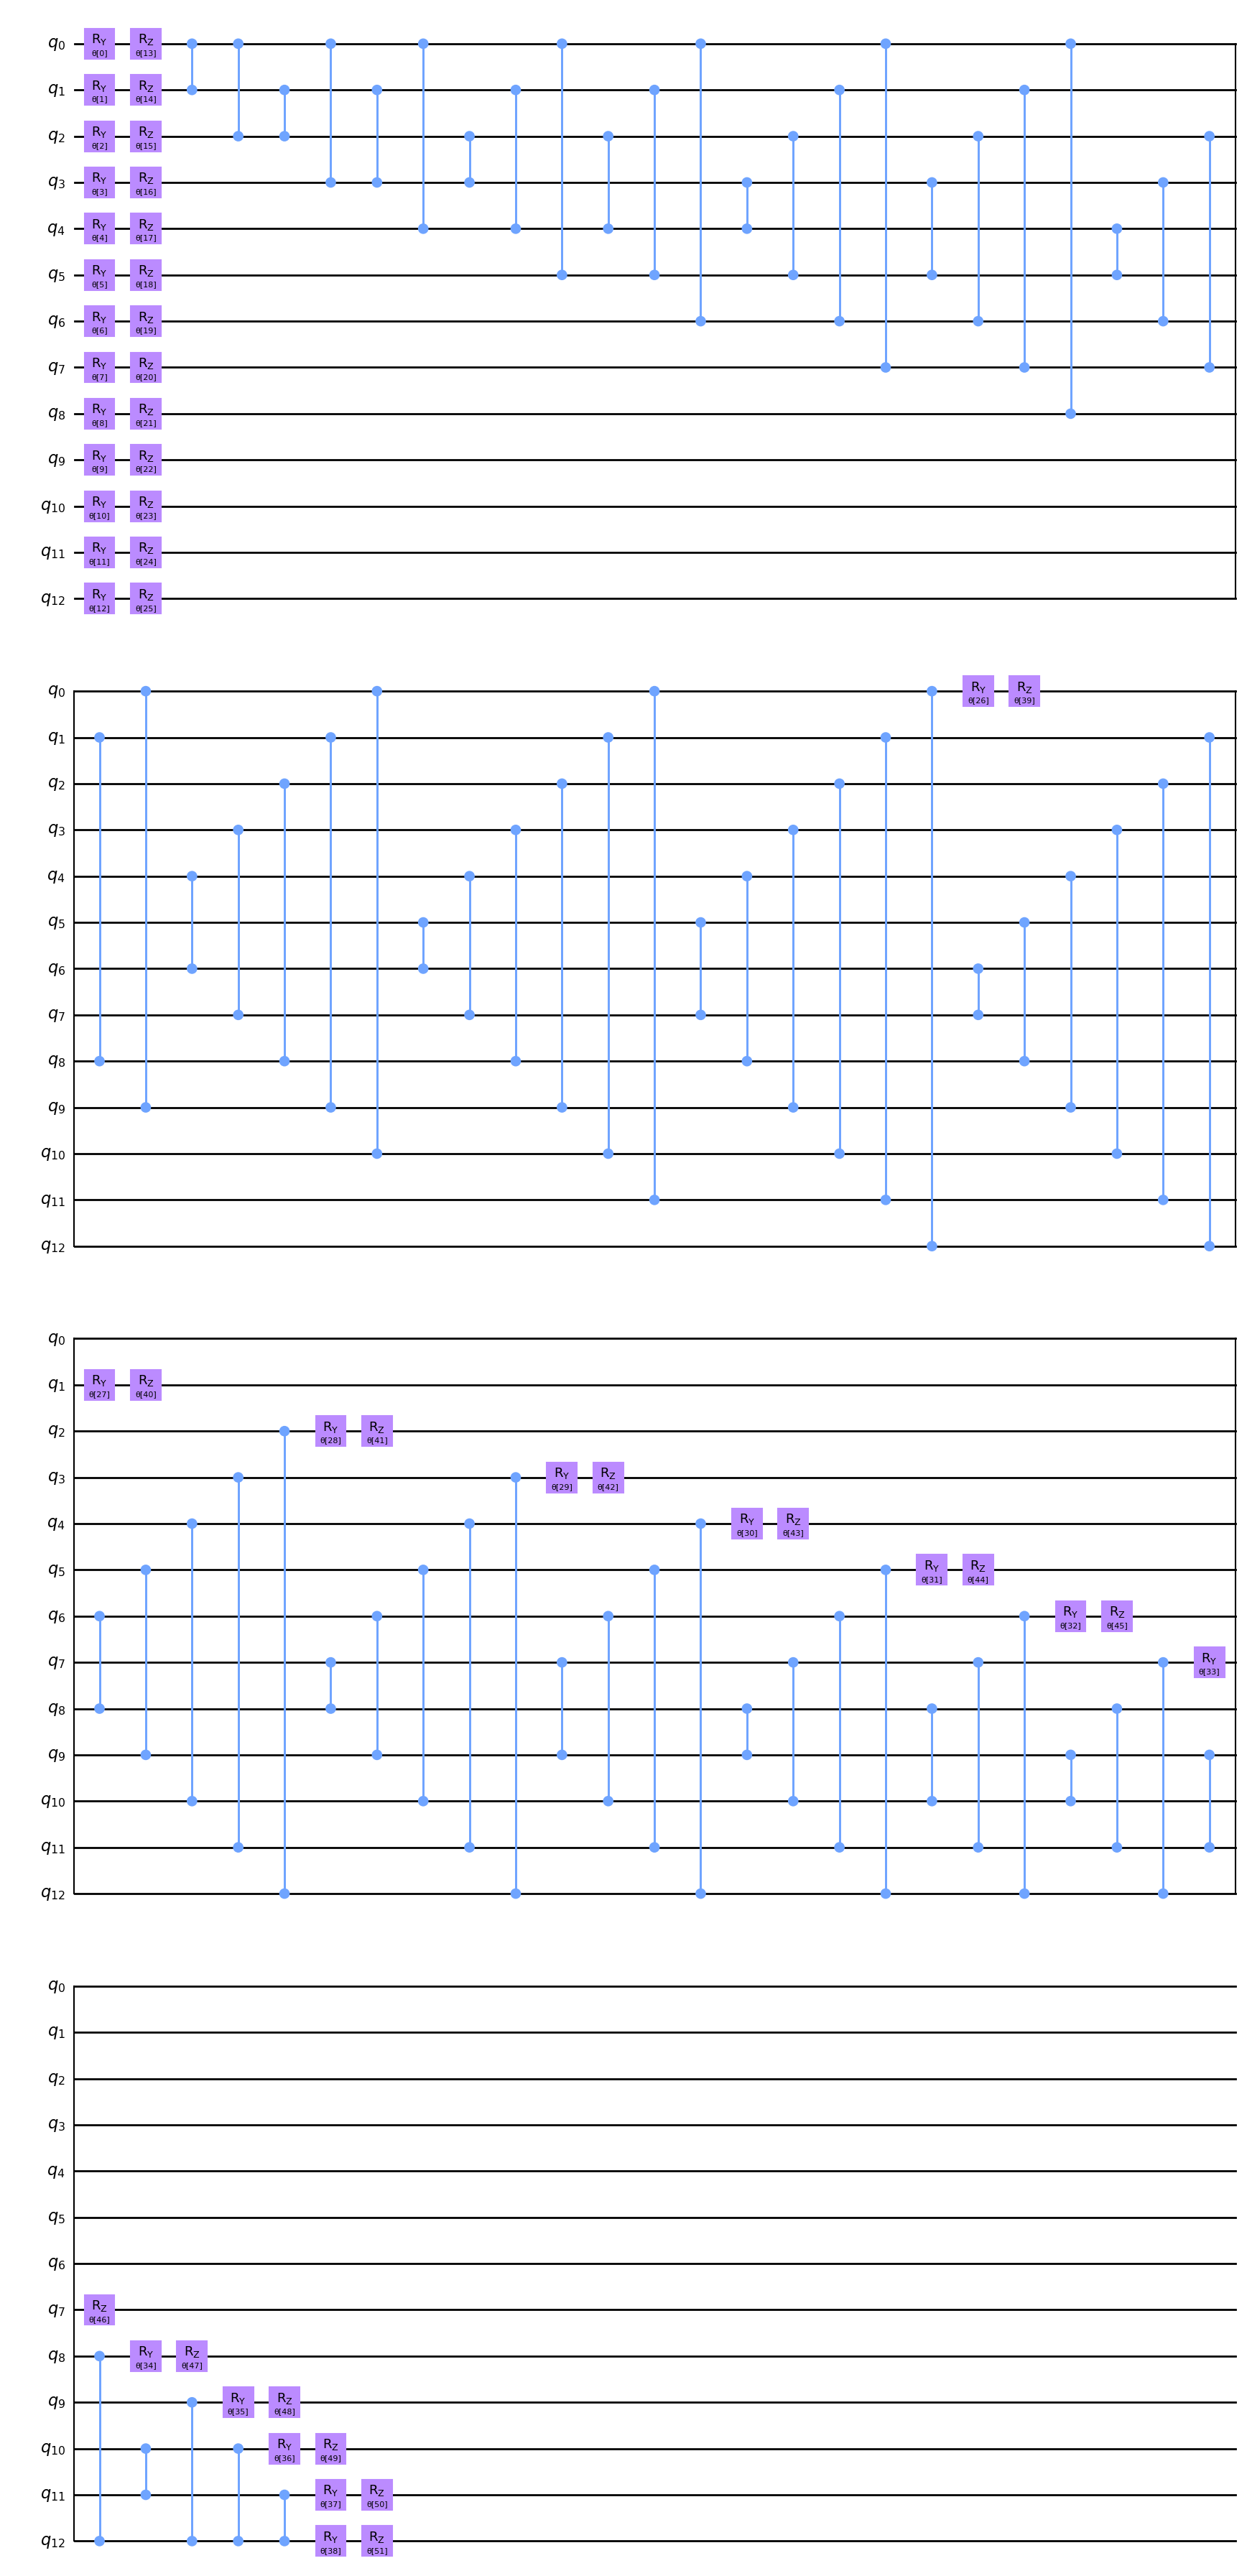

In [16]:
#Para el circuito clasificador utilizaremos TwoLocal
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import PauliTwoDesign

classifier = TwoLocal(13, ['ry', 'rz'], 'cz', reps=1)
classifier.decompose().draw("mpl")




#### Optimizador 

Finalmente, podemos definir un optimizador con el fin de mejorar al máximo posible los resultados obtenido. Para nuestro caso, hemos optado por la implementación del SPSA ?

In [17]:
#Hemos escogido el COBYLA optimizer para que el entrenamiento sea más rápido. Usamos la función de log de los apuntes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.optimizers import SPSA

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

log = OptimizerLog()


optimizer = SPSA(maxiter=100)

In [18]:

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

#Función que define la gráfica a mostrar mientras entrena el modelo

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()



#### VQC

Finalmente, armamos nuestra red neuronal en base a todas las componentes previamente explicadas. La función de pérdida escogida es la cross_entropy. ? 

### Ejecución de la QNN

Ahora, solo resta entrenar la red y graficar sus resultados.

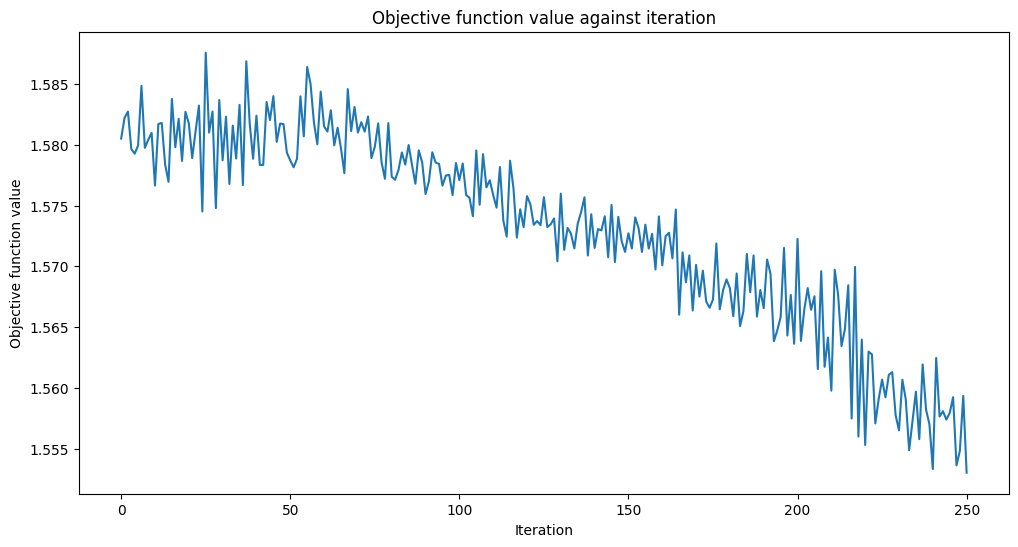

Training time: 6279 seconds


In [8]:

#Entrenamos el modelo

#Caso 1: Classifier TwoLocal, Optimizer SPSA


sampler = Sampler()


vqc = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)



start = time.time()
vqc.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

#Ploteamos los resultados


In [19]:
train_score_q1 = vqc.score(train_features, train_labels)
test_score_q1 = vqc.score(test_features, test_labels)
 
print(f"Quantum VQC on the training dataset: {train_score_q1:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q1:.2f}")

NameError: name 'vqc' is not defined

## Variaciones

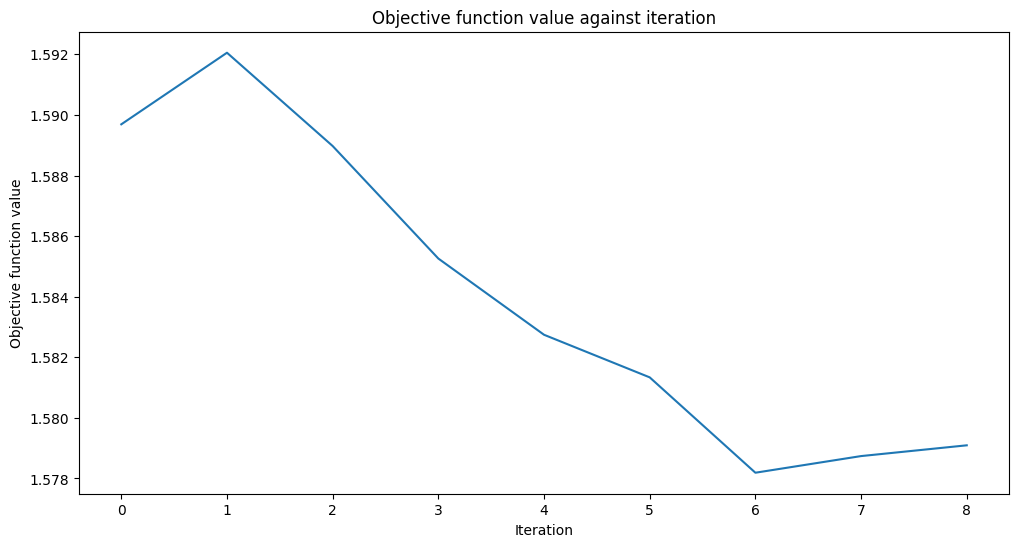

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [20]:

#Caso 2: Classifier TwoLocal, Optimizer COBYLA

classifier = TwoLocal(13, ['ry', 'rz'], 'cz', reps=1)
optimizer = COBYLA(maxiter=100)



vqc2 = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)

plt.clf()

start = time.time()
vqc2.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [10]:
rounded_train__labels=np.argmax(train_labels_oh, axis=1)
rounded_test_labels=np.argmax(test_labels_oh, axis=1)


train_score_q2 = vqc2.score(features_train, rounded_train__labels[1])
test_score_q2 = vqc2.score(features_test, rounded_test__labels[1])
 


print(f"Quantum VQC on the training dataset: {train_score_q2:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q2:.2f}")

NameError: name 'np' is not defined

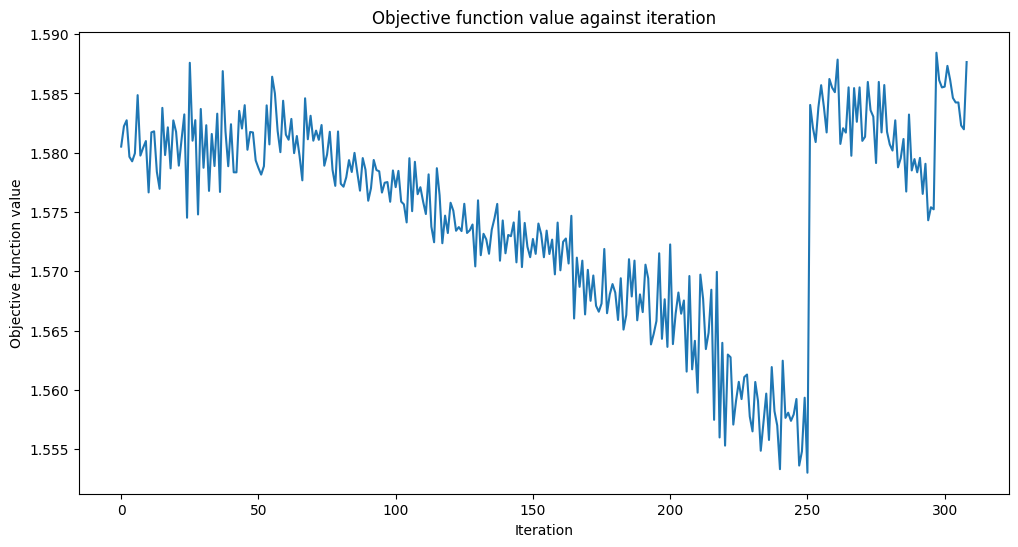

KeyboardInterrupt: 

In [16]:

#Caso 3: Classifier PauliTwoDesign, Optimizer SPSA

classifier = PauliTwoDesign(13, reps=1, insert_barriers=False)
optimizer = SPSA(maxiter=100)





vqc3 = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)

clear_output()
start = time.time()
vqc3.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [ ]:
train_score_q3 = vqc3.score(train_features, train_labels)
test_score_q3 = vqc3.score(test_features, test_labels)
 
print(f"Quantum VQC on the training dataset: {train_score_q3:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q3:.2f}")

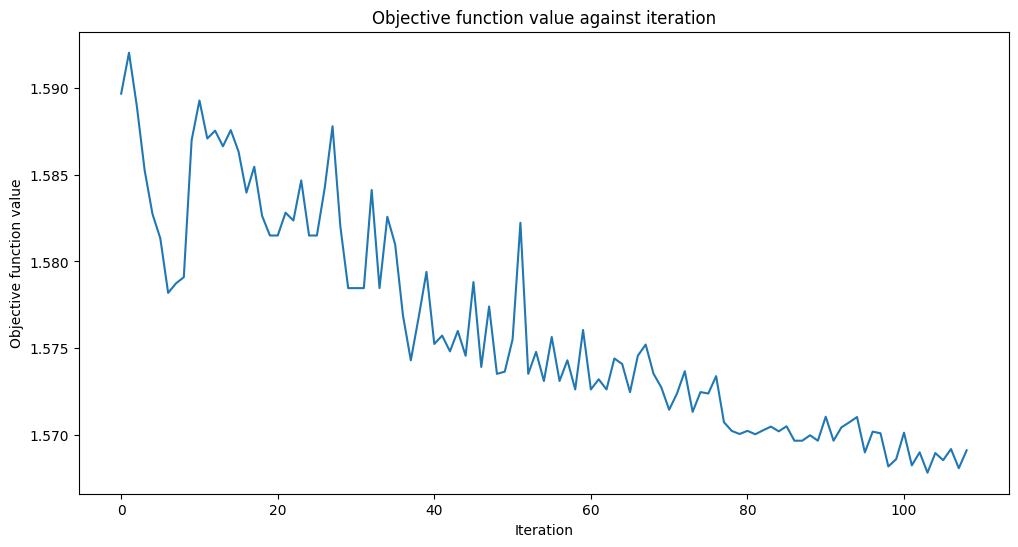

Training time: 1985 seconds


In [21]:

#Caso 4: Classifier PauliTwoDesign, Optimizer COBYLA

classifier = PauliTwoDesign(13, reps=1, insert_barriers=False)
optimizer = COBYLA(maxiter=100)


sampler = Sampler()


vqc4 = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)

plt.clf()

start = time.time()
vqc4.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [23]:

train_score_q4 = vqc4.score(features_train, train_labels_oh)
test_score_q4 = vqc4.score(features_test, test_labels_oh)
 
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

### Conclusiones

## Combinaciones que tenemos:

### ZZFeatureMap

    -PauliTwoDesign:
    
        -COBYLA y SPSA
        
    -TwoLocal
    
        -SPSA
        
        -En ejecución: COBYLA